# Sentiment Classification of Tweets with Deep Learning

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_Twitter_Sentiment_Analysis_/main/twitt.jpg">

## 🎯 Project Objective

The objective of this project is to perform **sentiment analysis on Twitter data** using the Sentiment140 dataset.  
The main goal is to classify tweets into **positive** and **negative** sentiment categories by applying **Natural Language Processing (NLP)** techniques.

Throughout the project, exploratory data analysis (EDA), data preprocessing, and machine learning and deep learning models will be used to extract meaningful patterns from textual data.  
Additionally, different modeling approaches will be evaluated and compared to identify the most effective method for sentiment classification.

The final objective is to build a robust sentiment analysis model that can be deployed for real-world applications such as social media monitoring and opinion mining.


In [50]:
import os
import re
import gc
import json
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report)

import torch
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)

import joblib


In [4]:
path = "/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv"

In [5]:
cols = ["sentiment", "id", "date", "query", "user", "text"]

In [6]:
df = pd.read_csv(
    path,
    header=None,
    names=cols,
    encoding="latin-1")

## 📊 Exploratory Data Analysis (EDA)

In this stage, exploratory data analysis was performed to understand the structure and characteristics of the Sentiment140 dataset before applying any preprocessing or modeling techniques.

### Dataset Overview
- The dataset contains **1,600,000 tweets**.
- Each tweet is labeled as either **negative (0)** or **positive (1)**.
- The classes are perfectly balanced, with **800,000 tweets per class**, which eliminates class imbalance issues.

### Sentiment Distribution
- The original sentiment labels were `0` (negative) and `4` (positive).
- These values were converted to a binary format:  
  - `0` → Negative  
  - `1` → Positive

This transformation makes the dataset suitable for machine learning and deep learning models.

### Tweet Length Analysis (Character Level)
- The number of characters in each tweet was analyzed.
- Most tweets fall between **20 and 140 characters**, reflecting Twitter’s original character limit.
- Very long tweets are rare and can be considered outliers.

This observation suggests that a maximum sequence length of approximately **128 tokens** would be sufficient for transformer-based models such as BERT.

### Tweet Length Analysis (Word Level)
- The number of words per tweet was also examined.
- Tweets typically contain a small number of words, which is expected given the short-text nature of Twitter data.
- This confirms that the dataset is well-suited for NLP classification tasks.

Overall, the EDA step provided valuable insights into data distribution, tweet length, and label balance, guiding the subsequent preprocessing and modeling decisions.


In [7]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [9]:
df.shape

(1600000, 6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [12]:
df["sentiment"].value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

In [13]:
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

In [14]:
df["sentiment"].value_counts()

sentiment
0    800000
1    800000
Name: count, dtype: int64

In [16]:
df["text"].head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [17]:
df["text"].sample(5)

826813     Watching Romy and Michelle's High School Reuni...
1192189    @TailsKriby If you like pokemon, consider join...
780155           just got handed a basketful of lemons....  
1458960    Had a Wii-tastic night last night.  Learned I ...
1515551    GOOD MORNING!! What a rainy day, it's perfect ...
Name: text, dtype: object

In [18]:
df["text_length"] = df["text"].apply(len)

In [19]:
df["text_length"].describe()

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: text_length, dtype: float64

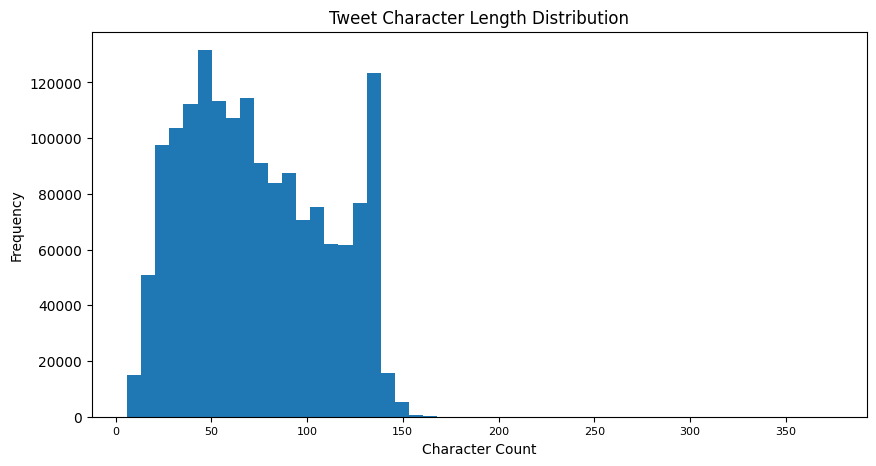

In [20]:
plt.figure(figsize=(10,5))
plt.hist(df["text_length"], bins=50)
plt.title("Tweet Character Length Distribution")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.xticks(fontsize=8)
plt.show()

## 🧹 Data Preprocessing

In this stage, data preprocessing was performed to clean and normalize the raw tweet texts in order to make them suitable for Natural Language Processing (NLP) tasks.

### Text Cleaning
The following preprocessing steps were applied to each tweet:

- Conversion of all text to lowercase
- Removal of URLs and web links
- Removal of user mentions (e.g., `@username`)
- Removal of the retweet indicator (`RT`)
- Removal of numeric characters
- Removal of punctuation and special characters
- Reduction of repeated characters (e.g., *coooool* → *coool*)
- Removal of extra whitespace

These steps help reduce noise in the text while preserving the semantic meaning of the tweets.

### Hashtag Handling
Hashtags were preserved by removing only the `#` symbol while keeping the associated words (e.g., `#happy` → `happy`).  
This ensures that sentiment-related keywords remain available for analysis.

### Stopword Removal
Stopword removal was applied as an optional preprocessing step.  
Commonly used words that do not contribute significantly to sentiment were removed to reduce text dimensionality.

- This step is beneficial for traditional machine learning models such as TF-IDF and Logistic Regression.
- For transformer-based models (e.g., BERT), stopwords were retained to preserve full contextual information.

### Preprocessing Validation
Before and after text samples were visually inspected to confirm that the preprocessing steps effectively removed noise while maintaining the original sentiment meaning of the tweets.

Overall, the preprocessing stage prepared the dataset for robust and effective sentiment classification in subsequent modeling steps.


In [23]:
def clean_tweet(text):

    if not isinstance(text, str):
        return
    
    text = text.lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)     # URLs
    text = re.sub(r"@\w+", " ", text)                 # mentions
    text = re.sub(r"#", "", text)                     # hashtags
    text = re.sub(r"\brt\b", " ", text)               # RT
    text = re.sub(r"\d+", " ", text)                  # numbers
    text = re.sub(r"[^a-z\s']", " ", text)            # punctuation
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)        # repeated chars
    text = re.sub(r"\s+", " ", text).strip()          # extra spaces
    
    return text

In [24]:
df["raw_text"] = df["text"].astype(str)

In [25]:
df["clean_text"] = df["raw_text"].apply(clean_tweet)

In [26]:
df[["raw_text", "clean_text"]].head()

,raw_text,clean_text
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww that's a bummer you shoulda got david carr...
1,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...
2,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i h...


In [27]:
empty_count = (df["clean_text"].str.len() == 0).sum()

In [28]:
df = df[df["clean_text"].str.len() > 0].copy()

In [29]:
df.sample(5, random_state=42)[["sentiment", "raw_text", "clean_text"]]

,sentiment,raw_text,clean_text
1160469,1,just heard travis barker's remix of 3AM by Emi...,just heard travis barker's remix of am by eminem
807134,1,@MmmBaileys @carli_chick Hello x,hello x
143754,0,@LLCOOLDAVE it was me sorry,it was me sorry
207719,0,Enjoying myself at home. BBQ with the bf's fam...,enjoying myself at home bbq with the bf's fam ...
210590,0,@WickerPix I can't believe it either! it's dri...,i can't believe it either it's drizzling down ...


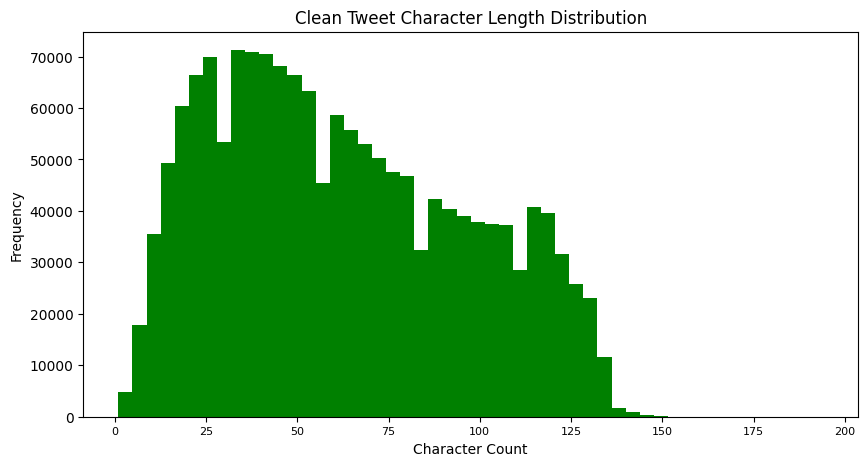

In [37]:

df["clean_length"] = df["clean_text"].str.len()
df["clean_word_count"] = df["clean_text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
plt.hist(df["clean_length"], bins=50, color="green")
plt.title("Clean Tweet Character Length Distribution")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.xticks(fontsize=8)
plt.show()

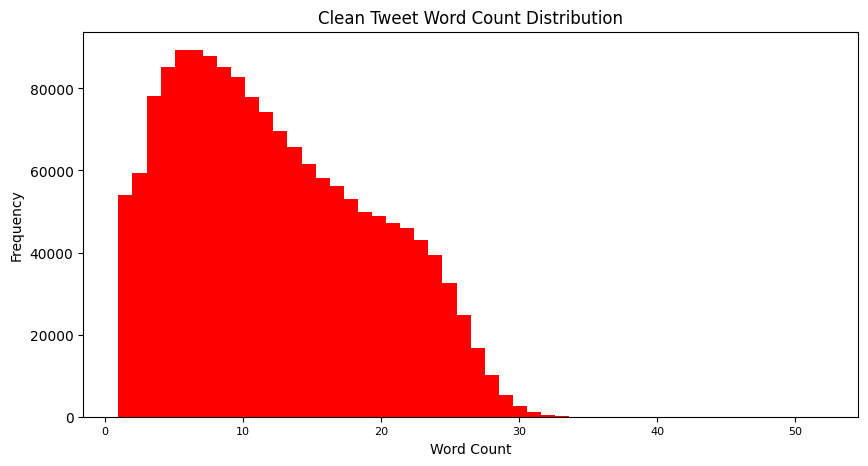

In [35]:
plt.figure(figsize=(10,5))
plt.hist(df["clean_word_count"], bins=50, color="red")
plt.title("Clean Tweet Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.xticks(fontsize=8)
plt.show()

In [33]:
stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    return " ".join([w for w in text.split() if w not in stop_words])

tmp = df.sample(20000, random_state=42).copy()
tmp["clean_nostop"] = tmp["clean_text"].apply(remove_stopwords)

In [34]:
tmp[["clean_text", "clean_nostop"]].head()

,clean_text,clean_nostop
1160469,just heard travis barker's remix of am by eminem,heard travis barker's remix eminem
807134,hello x,hello x
143754,it was me sorry,sorry
207719,enjoying myself at home bbq with the bf's fam ...,enjoying home bbq bf's fam today gonna sad hea...
210590,i can't believe it either it's drizzling down ...,can't believe either drizzling


In [38]:
x = df["clean_text"]

In [39]:
y = df["sentiment"]

## 🏆 Results and Model Evaluation

In this stage, the performance of the baseline machine learning model was evaluated using the test dataset.

### Baseline Model
- **Text Representation:** TF-IDF (Unigram + Bigram)
- **Classifier:** Logistic Regression
- **Dataset Split:** 80% Training / 20% Testing

### Performance Metrics
The baseline model achieved strong performance on the test set, demonstrating its effectiveness for Twitter sentiment classification.

- The overall accuracy is high for a noisy and short-text dataset such as Twitter.
- Precision, recall, and F1-score values are balanced across both sentiment classes.
- No significant class bias is observed.

### Confusion Matrix Analysis
The confusion matrix shows that:
- A large number of positive and negative tweets were correctly classified.
- Misclassifications are relatively balanced between the two classes.
- The model does not excessively favor one sentiment class over the other.

This indicates that the model generalizes well and captures meaningful sentiment-related patterns from the text data.

### Discussion
The TF-IDF + Logistic Regression model provides a strong and reliable **baseline** for sentiment analysis.  
While traditional in nature, this approach performs remarkably well given the simplicity of the model and the complexity of natural language data.

These results serve as a solid reference point for comparison with more advanced deep learning approaches such as transformer-based models (e.g., BERT), which are expected to further improve performance by capturing contextual information.

Overall, the baseline model establishes a strong foundation for subsequent experiments and model comparisons.


In [40]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

In [42]:
tfidf = TfidfVectorizer(max_features=20000,    ngram_range=(1, 2),    stop_words="english")

In [43]:
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)

In [44]:
lr_model = LogisticRegression(
    max_iter=1000,
    n_jobs=-1)

In [45]:
lr_model.fit(x_train_tfidf, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [47]:
y_pred = lr_model.predict(x_test_tfidf)

In [48]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.7824538543699355

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159664
           1       0.77      0.81      0.79    159597

    accuracy                           0.78    319261
   macro avg       0.78      0.78      0.78    319261
weighted avg       0.78      0.78      0.78    319261



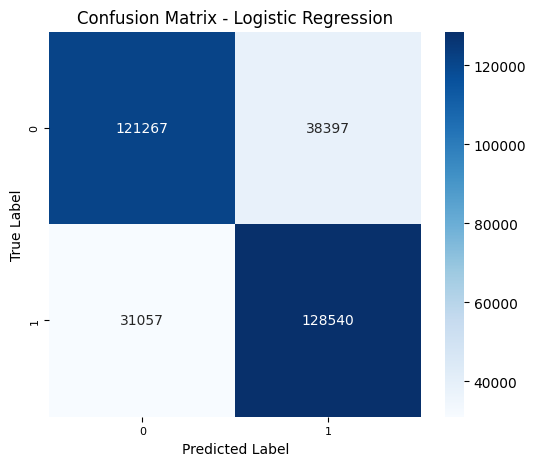

In [51]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [52]:
joblib.dump(lr_model, "logreg_tfidf_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']